In [1]:
import torch
from torch import nn
from utils import *
import collections

In [6]:
# tokenizing

# import nltk
# from nltk.tokenize import word_tokenize
# nltk.download('punkt')

def tokenize(lines):
    """Split text lines into word or character tokens."""
    # tokens = word_tokenize(lines)
    tokens = [line.split() for line in lines]

    return tokens

In [5]:
import pandas as pd
train_path = './pei_project/train_labeled.csv'
test_path = './pei_project/test_labeled.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

test_df.columns

Index(['review', 'label'], dtype='object')

In [8]:
X_train, y_train, X_test, y_test = [], [], [], []
for x, y in zip(train_df['review'].tolist(), train_df['label'].tolist()):
    X_train.append(x)
    y_train.append(y)

for x, y in zip(test_df['review'].tolist(), test_df['label'].tolist()):
    X_test.append(x)
    y_test.append(y)

train_tokens = tokenize(X_train)
test_tokens = tokenize(X_test)

train_tokens[0][:10]

['"It', 'has', 'no', 'side', 'effect,', 'I', 'take', 'it', 'in', 'combination']

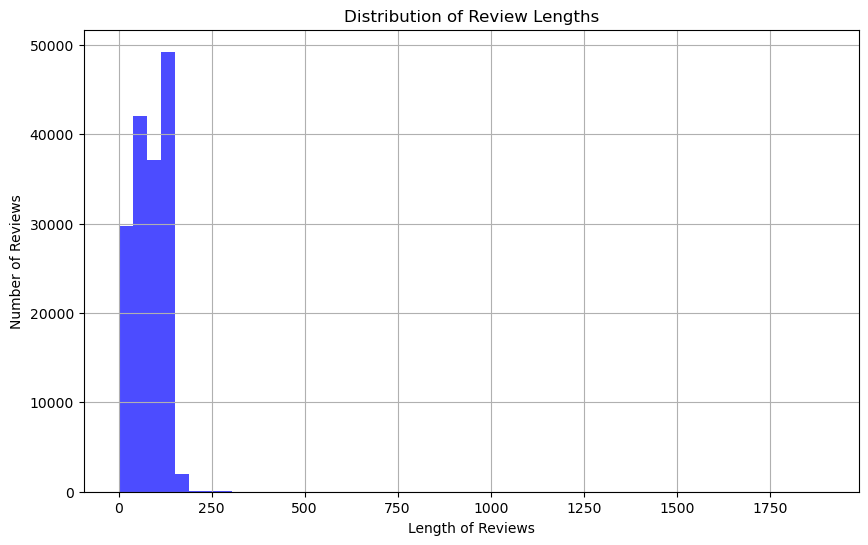

In [10]:
### START CODE HERE ###
import matplotlib.pyplot as plt

def plot_review_lengths(x):
    lengths = [len(i) for i in x]
    
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=50, color='blue', alpha=0.7)
    plt.title('Distribution of Review Lengths')
    plt.xlabel('Length of Reviews')
    plt.ylabel('Number of Reviews')
    plt.grid(True)
    plt.show()

plot_review_lengths(train_tokens)

### END CODE HERE ###

In [11]:
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self): 
        return self.token_to_idx['<unk>']


In [12]:
def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

In [13]:
import torch
from torch.utils.data import DataLoader, TensorDataset

def load_data_imdb(batch_size, num_steps=500):
    """Return data loader and the vocabulary of the IMDb review dataset."""

    vocab = Vocab(tokens=train_tokens, min_freq=5, reserved_tokens=['<pad>'])

    # Numericalize and pad the data
    train_numerical = [vocab[line] for line in train_tokens]
    test_numerical = [vocab[line] for line in test_tokens]
    train_numerical = [truncate_pad(line, num_steps, vocab['<pad>']) for line in train_numerical]
    test_numerical = [truncate_pad(line, num_steps, vocab['<pad>']) for line in test_numerical]

    # Convert lists to tensor
    train_features = torch.tensor(train_numerical)
    test_features = torch.tensor(test_numerical)
    train_labels = torch.tensor(y_train)
    test_labels = torch.tensor(y_test)

    # Create data loaders
    train_dataset = TensorDataset(train_features, train_labels)
    test_dataset = TensorDataset(test_features, test_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, vocab

In [14]:
batch_size = 64
train_iter, test_iter, vocab = load_data_imdb(batch_size)

In [15]:
def train(net, train_iter, test_iter, loss, trainer, num_epochs):
    ### START CODE HERE ###
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        net.train()
        sum_loss, sum_accuracy, num_examples = 0, 0, 0
        for features, labels in train_iter:
            features, labels = features.to(device), labels.to(device)
            
            # Forward pass
            outputs = net(features)
            l = loss(outputs, labels.unsqueeze(1).float()).mean()

            # Backward and optimize
            trainer.zero_grad()
            l.backward()
            
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1) # to prevent from gradient diminishing
            trainer.step()

            sum_loss += l.item() * labels.shape[0]
            sum_accuracy += (outputs.argmax(dim=1) == labels).sum().item()
            num_examples += labels.shape[0]

        for name, param in net.named_parameters():
            if param.grad is not None:
                print(f"Gradient norm for {name}: {param.grad.norm().item()}")
                break
                        
        train_losses.append(sum_loss / num_examples)
        train_accuracy = evaluate_accuracy(net, train_iter, device)
        train_accuracies.append(train_accuracy)
        
        # Evaluation mode
        test_accuracy = evaluate_accuracy(net, test_iter, device)
        test_accuracies.append(test_accuracy)
        
        print(f'Epoch {epoch + 1}, Loss: {train_losses[-1]:.4f}, '
              f'Training Acc: {train_accuracies[-1]:.4f}, Testing Acc: {test_accuracy:.4f}')

    plt.figure(figsize=(15, 5))  
    
    # Subplot for Training Loss
    plt.subplot(1, 3, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, 'r-', label="Training Loss")
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    # Subplot for Training Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, 'b-', label="Training Accuracy")
    plt.title("Training Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Subplot for Testing Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(range(1, num_epochs + 1), test_accuracies, 'g-', label="Testing Accuracy")
    plt.title("Testing Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def evaluate_accuracy(net, data_iter, device):
    net.eval()
    num_correct, num_samples = 0, 0
    
    with torch.no_grad():  # No gradient needed for evaluation, which saves memory and computations
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            outputs = net(X)
            
            probabilities = torch.sigmoid(outputs)
            
            predicted = (probabilities > 0.5).type(torch.int32)
            
            # Flatten y
            y = y.view_as(predicted)
            
            num_correct += (predicted == y).sum().item()
            num_samples += y.size(0)
    
    return num_correct / num_samples

    ### END CODE HERE ### 

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels, dropout=0.5, **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)

        # Create multiple convolutional layers
        self.conv_layers = nn.ModuleList([
            nn.Conv2d(1, num_ch, (k, embed_size)) for k, num_ch in zip(kernel_sizes, num_channels)
        ])
        
        # Dropout layer
        self.dropout = nn.Dropout(p=dropout)
        
        # FC
        self.fc = nn.Linear(sum(num_channels), 1) 

    def forward(self, inputs):
        # Embedding layer - outputs: (batch_size, sentence_length, embed_size)
        embedded = self.embedding(inputs).unsqueeze(1)  # Shape: (batch_size, 1, sentence_length, embed_size)
        
        # Convolutional and Pooling Layers
        conv_results = [F.relu(conv(embedded)).squeeze(3) for conv in self.conv_layers]
        pooled_results = [F.max_pool1d(r, r.size(2)).squeeze(2) for r in conv_results]
        
        # Concatenate all the pooled features
        cat = torch.cat(pooled_results, 1)
        cat = self.dropout(cat)
        
        # Fully connected layer
        output = self.fc(cat)
        return output



In [17]:
def init_weights(module):
    # print(f"Initializing weights for {module.__class__.__name__}")
    if isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)
    elif isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, 0, 0.01)
        nn.init.constant_(module.bias, 0)
    elif isinstance(module, nn.Embedding):
        nn.init.uniform_(module.weight, -0.05, 0.05)

# Example of applying the initialization


In [18]:
glove_embedding = TokenEmbedding('glove.6b.100d', './data')
embeds = glove_embedding[vocab.idx_to_token]

In [19]:
### START CODE HERE ###
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100] ### YOUR CODE HERE ###
net_cnn = TextCNN(vocab_size=len(vocab), embed_size=embed_size, kernel_sizes=kernel_sizes, num_channels=nums_channels, dropout=0.0)
net_cnn.apply(init_weights) ### YOUR CODE HERE ###

net_cnn.embedding.weight.data.copy_(embeds)
net_cnn.embedding.weight.requires_grad = False  
### END CODE HERE ### 

Gradient norm for conv_layers.0.weight: 0.4447847604751587
Epoch 1, Loss: 0.4443, Training Acc: 0.8472, Testing Acc: 0.8255
Gradient norm for conv_layers.0.weight: 0.4672083556652069
Epoch 2, Loss: 0.3572, Training Acc: 0.8783, Testing Acc: 0.8444
Gradient norm for conv_layers.0.weight: 0.40648922324180603
Epoch 3, Loss: 0.3039, Training Acc: 0.9075, Testing Acc: 0.8590
Gradient norm for conv_layers.0.weight: 0.3676905333995819
Epoch 4, Loss: 0.2588, Training Acc: 0.9304, Testing Acc: 0.8708
Gradient norm for conv_layers.0.weight: 0.35202258825302124
Epoch 5, Loss: 0.2206, Training Acc: 0.9427, Testing Acc: 0.8774
Gradient norm for conv_layers.0.weight: 0.46598145365715027
Epoch 6, Loss: 0.1894, Training Acc: 0.9330, Testing Acc: 0.8641
Gradient norm for conv_layers.0.weight: 0.41603195667266846
Epoch 7, Loss: 0.1611, Training Acc: 0.8942, Testing Acc: 0.8271
Gradient norm for conv_layers.0.weight: 0.34917765855789185
Epoch 8, Loss: 0.1358, Training Acc: 0.9727, Testing Acc: 0.9011
Gra

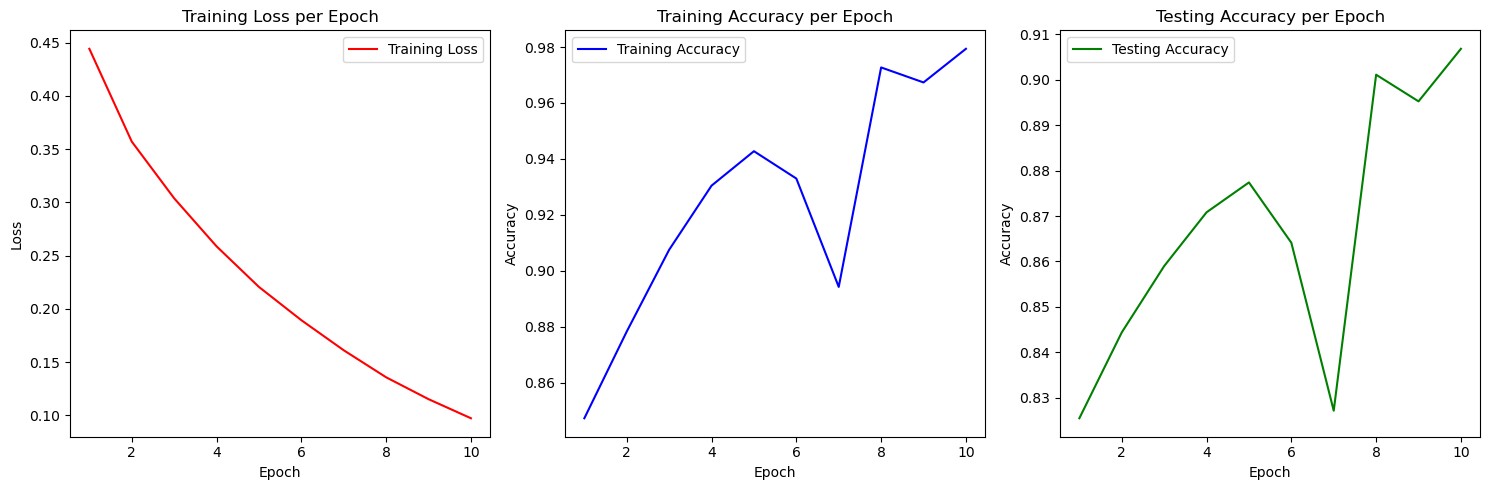

In [20]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.Adam(net_cnn.parameters(), lr=lr)
loss = nn.BCEWithLogitsLoss() 
train(net_cnn, train_iter, test_iter, loss, trainer, num_epochs)

In [21]:
def predict_sentiment(net, vocab, sequence, max_seq_len=512):
    """Predict the sentiment of a text sequence."""
    ### START CODE HERE ###
    net.eval()

    # Tokenize and convert tokens to indices
    tokenized = sequence.lower().split()
    indexed = [vocab[token] for token in tokenized]

    # Truncate and pad
    padded = truncate_pad(indexed, max_seq_len, vocab['<pad>'])
    tensor = torch.tensor([padded], dtype=torch.long)

    tensor = tensor.to(next(net.parameters()).device)

    with torch.no_grad():
        output = net(tensor)

    probability = torch.sigmoid(output)

    predicted_probability = probability.item()
    predicted_sentiment = 'positive' if predicted_probability >= 0.5 else 'negative'

    return predicted_sentiment, predicted_probability
    ### END CODE HERE ### 

In [23]:
predict_sentiment(net_cnn, vocab, '"I smoked for 50+ years.  Took it for one week and that was it.  I didn&#039;t think it was possible for me to quit.  It has been 6 years now.  Great product."')

('positive', 0.9998539686203003)